__Group 20__:
- __Inês Rocha 20220052@novaims.unl.pt__
- __Pedro Ferreira 20220589@novaims.unl.pt__
- __Quintino Fernandes 20220634@novaims.unl.pt__

__Dataset__: https://drive.google.com/drive/folders/1NJOCRQ3ynA4BEOvWj5Ypr6iwi108LfOh?usp=share_link

(This is the non-zipped version, so one can see the images themselves. For the notebook, we use a zipped version, whose link is in the cell where the folder is imported. This is the dataset that we import to the model notebook, so it already has transformations that are made in preprocessing).

__Summary of the notebook:__

The objective in this notebook is to get the best model possible from the baseline of residual neural network architecture:

- We tried 10 different versions of the algorithm;

- In each one, we changed things like:
    - the activation function;
    - the preprocessing pipeline, by including or not data augmentation;
    - the layers themselves, particularly the bottleneck blocks;
    - the amount of layers;
    - the number of filters/units in some layers, playing around also with some parameters of the bottleneck class, to make sure the neural network still works.

- In the end, we keep the model that performed the better in the unseen data. We also kept the second best in case some optimization makes it better than the chosen one.

__The problem__: We have a dataset with around 10000 photo images of skin marks in humans. They are all labeled as a type of cancer, so our objective is to train a neural network and improve it to the point where it can distinguish from the various types of cancer, as accurately as it can. To do so, we will try some variations of a particular neural network architecture (the residual neural network), changing some things to try to adapt a neural network to our specific problem.

__References:__
1. [Algorithms for Skin Cancer Classification from Dermoscopic Images (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8945332/)
2. [Skin Cancer Classification from Dermoscopic Images: A Systematic Review (2022)](https://www.mdpi.com/1999-4893/15/11/438)
3. [Skin Cancer Classification: A Systematic Review (2022)](https://www.frontiersin.org/articles/10.3389/fonc.2022.893972/full)
4. [Getting started with KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)
5. [Create A Confusion Matrix](https://deeplizard.com/learn/video/km7pxKy4UHU)
6. [Confusion Matrix Plot, by user Alexandre Catalano](https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory)
7. [ELU, by Saurabh Singh](https://deeplearninguniversity.com/elu-as-an-activation-function-in-neural-networks/)


# 1. Import the dataset

In this section we upload our dataset to the workbook filesystem and split our data into **train**, **test** and **validation** sets.

We begin by importing the necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import shutil
import random 
import zipfile
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import gdown

We upload the zip file with our Skin Cancer dataset (HAM10000).

In [ ]:
url = 'https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H
To: /content/data.zip
100%|██████████| 698M/698M [00:18<00:00, 37.4MB/s]


'data.zip'

In this cell we extract the files from the data.zip file and loading into this workbook filesystem. 

In [ ]:
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()
path = ""

After extracting all of the files, we define the paths for our train, test and validation folders.

In [ ]:
training_folder, val_folder, testing_folder = "/content/transformed_data/transformed_train/", \
"/content/transformed_data/transformed_val/", "/content/transformed_data/transformed_test/"

For the sake of ensuring that the data isn't continuously duplicated, we created this boolean flag for the function created bellow.

In [ ]:
run = True

The **function make__copies()**, receives a folders and copies each photo n times and then stores it in the same folder. We will use this function as way to balance the dataset.

In [ ]:
def make_n_copies(folder, n_copies):

# Loop through each file in the images folder
  for image in os.listdir(folder):
    file_path = os.path.join(folder, image)
    # Create n_copies of the file
    for i in range(n_copies):
      new_filename = f"{image.split('.')[0]}_copy{i+1}.jpg"
      new_file_path = os.path.join(folder, new_filename)
      shutil.copy(file_path, new_file_path)


if run:
  make_n_copies(training_folder + 'akiec', 18)
  make_n_copies(training_folder + 'bcc', 11)
  make_n_copies(training_folder + 'bkl', 5)
  make_n_copies(training_folder + 'df', 51)
  make_n_copies(training_folder + 'mel', 5)
  make_n_copies(training_folder + 'vasc', 42)     


We used the fuction **make_n_copies()**,to populate the target folders in all folders except **nv**, because it had significantly more records than the others.

Here we define the main parameters to import the images from the directory to a tf dataset.

In [ ]:
image_size=(128,128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

We defined the **image size** for our dataset to be **128x128 pixels**, because its a standart measure for iamges and so that images with diferent shapes dont conflict with our models. 

Our label mode is **categorical**, since our optimization problem is to predict which type of skin cancer is present in an image.

In this next cell, we generate our 3 tf datasets to train and test our model, with the parameters that we defined in the cell above.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)

ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 30185 files belonging to 7 classes.
Found 1703 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


Here we print the class name of the ds_train to confim that we have all the target labels.

Legend of what exactly the target names stand for:
- "akiec": actinic keratoses and intraepithelial carcinoma / Bowen's disease
- "bcc": basal cell carcinoma
- "bkl": benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
- "df": dermatofibroma
- "mel": melanoma
- "nv": melanocytic nevi
- "vasc": vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


# 4. Handcrafted model

First of all, we need to define some things prior to starting the models. Below we iterate in our training, particularly to get the input shape automatically.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

In [ ]:
input_shape = tuple(batch_x_train.shape)

The function below is based on the procedure of our deep learning classes. We input the model, learning rate and nr of epochs and it will give us a print of each epoch's measures. We added the precision and recall to the accuracy and AUC because we have an unbalanced set and even having oversampled the training set, we kept the other two sets unbalanced, because we thought it would simulate better real life. The function will also return the history callbacks of the model, so we can later use them to compare models. We also added the f1score to the history dataframe we are outputing, using the precision and recall, because it is a good measure of quality of a model with imbalanced data.

In [ ]:
def compilation(cnn, epochs = 10, optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)):
  cnn.compile(loss="categorical_crossentropy",
              optimizer= optimizer,
              metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                       metrics.AUC(name='AUROC'),
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])
  
  history = cnn.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
  # 3. 
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  #calculating the f1score for each epoch (train and validation)
  df_hist['f1'] = 2*(df_hist['precision']*df_hist['recall'])/(df_hist['precision'] + df_hist['recall'])
  df_hist['val_f1'] = 2*(df_hist['val_precision']*df_hist['val_recall'])/(df_hist['val_precision']+df_hist['val_recall'])
  
  return df_hist

The function below, also based on the classes, to plot the progress of the model through the epochs. Because of the imbalance, we decided it would be more important to plot the f1_score, while still keeping an eye on the accuracy, so the rest of the measures won't be seen in this plot, but will always be visible inside the model's history. The loss function will also always be present.


In [ ]:
def plot_hist(df_hist):
  secondary_y = ["f1", "val_f1", "accuracy", "val_accuracy"] 

  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y, 
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves", 
                    style=[".--", ".-"]*3,
                    color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("F1 Score and Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

Let's define a function to compare two models. It does two plots next to one another with the same metrics. F1 score and Loss function are our chosen metrics to compare the evolution of the model throughout the epochs in terms of comparing models.

In [ ]:
def compare_models(model1_hist, model2_hist):

  secondary_y = ["f1", "val_f1"] 

  ax = model1_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y, 
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves", 
                    style=[".--", ".-"]*3,
                    color=['darkred', 'indianred', "darkblue", "royalblue"], 
                          alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("F1 Score")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  ax = model2_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y, 
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves", 
                    style=[".--", ".-"]*3,
                    color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen"], 
                          alpha=0.75, fontsize=10)
  
  
  plt.show()

The function below will allow us to build a confusion matrix. It is heavily based on deeplizard's code (reference 5).

In [ ]:
#Labels for the confusion matrix plot
target_labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

#function from deeplizard
def plot_confusion_matrix(cm, classes,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Model 1

We decided that our base model's architecture would be the ResNet we defined in our classes, as it is a fairly complex model, while having some caviats that allow it to be efficient (like the fact that it is built on residual bottleneck blocks).

So, we had to define the Bottleneck block and the Custom Residual NN classes, based on keras' models. We had to use an output layer with 7 neurons and the softmax activation function, to adapt it to our multiclass problem.

In [ ]:
# bottleneck blocks are used so we decrease the number of parameters of the network.
# We use a 1x1 conv layer in the out and in, while in the middle we use a conv 3*3.
# Usually, for the same thing we'd use a kernel which would increase the parameters

class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    # The bottleneck block itself is here, where we can see the three stacked 
    # convolutional layers, each stacked layer having batch normalization and
    # the activation function.
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x 

Now we just need to define the custom residual network class. We will do this several times, because we want to iteratively get the best model possible, and to do so we will need to change the content the class.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

Now we have to create an instance of the model, then build it and check its characteristics.

In [ ]:
# Create an instance of CustomCNN
cnn1 = CustomResNet(seed=seed)
# Builds the DAG 
cnn1.build(input_shape)
# Check the network
cnn1.summary()

Model: "custom_res_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_13 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_2 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_3 (Bottlen  multiple                 96384     
 eckBlock)                                        

We will use the compilation function we defined earlier to compile and get the history callbacks of our model. This process will be repeated with the other models.

In [ ]:
model1_hist = compilation(cnn1)

Epoch 1/10
472/472 [==============================] - 68s 139ms/step - loss: 1.4079 - accuracy: 0.5123 - AUROC: 0.8414 - precision: 0.7057 - recall: 0.2947 - val_loss: 1.3953 - val_accuracy: 0.4962 - val_AUROC: 0.8335 - val_precision: 0.6789 - val_recall: 0.3699
Epoch 2/10
472/472 [==============================] - 65s 136ms/step - loss: 0.9190 - accuracy: 0.6898 - AUROC: 0.9333 - precision: 0.8422 - recall: 0.4831 - val_loss: 1.1608 - val_accuracy: 0.5666 - val_AUROC: 0.8887 - val_precision: 0.7013 - val_recall: 0.4563
Epoch 3/10
472/472 [==============================] - 67s 138ms/step - loss: 0.7616 - accuracy: 0.7581 - AUROC: 0.9567 - precision: 0.8817 - recall: 0.5924 - val_loss: 1.1392 - val_accuracy: 0.5643 - val_AUROC: 0.8970 - val_precision: 0.6694 - val_recall: 0.4827
Epoch 4/10
472/472 [==============================] - 65s 136ms/step - loss: 0.6561 - accuracy: 0.8026 - AUROC: 0.9694 - precision: 0.9030 - recall: 0.6660 - val_loss: 1.1313 - val_accuracy: 0.5725 - val_AUROC: 

Plotting the history's most relevant metrics:

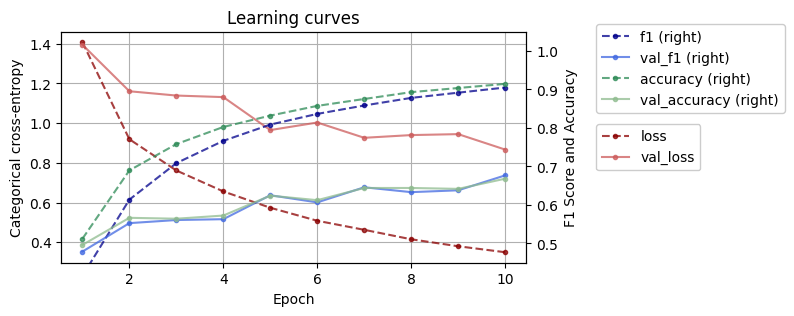

In [ ]:
plot_hist(model1_hist)

We see that there is a clear overfitting. We can see that the val scores are around 65% but the training ones around 90%. That's a lot of overfitting. But below we will see the score in the test set.

Let's use the model on the test set and check the confusion matrix as well.

In [ ]:
test_scores1 = cnn1.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores1[1]}')

print(f'Test f1_score: {2*test_scores1[-2]*test_scores1[-1]/(test_scores1[-2]+test_scores1[-1])}')

Test Accuracy: 0.6706587076187134
Test f1_score: 0.6666666624959454


Finally, we want to plot a confusion matrix.

In [ ]:
# Getting the labels from ds_test
labels1 =  np.array([])
for x, y in ds_test:
  labels1 = np.concatenate([labels1, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions1 = cnn1.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 3s 72ms/step


Confusion matrix, without normalization
[[  1   2   6   0   7  33   0]
 [  1   7   7   0  17  45   0]
 [  5  10  15   1  29 100   5]
 [  2   0   3   0   3   8   1]
 [  4   8  19   1  27 105   3]
 [ 41  67  83  11 160 626  18]
 [  0   1   1   0   2  16   2]]


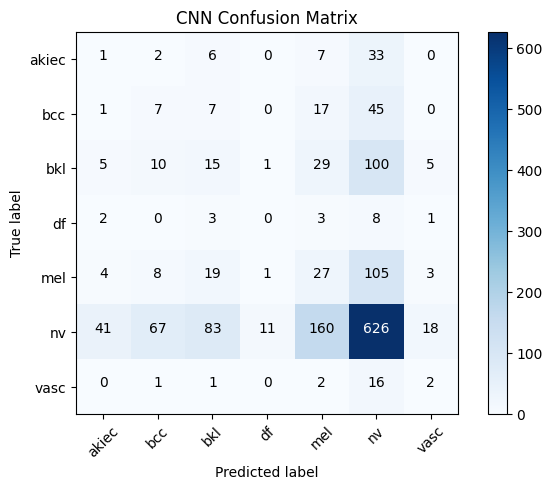

In [ ]:
cm = confusion_matrix(y_true= labels1, y_pred=predictions1.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix indicates that the majority class, nv, is fairly well predicted, specially when comparing it to the other ones. But the model is having trouble classifying the other classes. Besides that, it is classifying nv, the majority class, as other classes, which was less expected.

### Model 2

Because we had so much overfitting in the standard resnet model we defined earlier, we want to, first of all, decrease that. So, we will try the same model, but add data augmentation before the preprocessing batch normalization layer. That was defined in the previous notebook. Note that we did not randomize contrast and brightness. This is because as we are checking image from skin photos, we think color and contrast might be important, as they are probably the main characteristics of a skin mark. So, we just do rotation, zoom and translation randomly to images, before they enter the rest of the layers.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()

        # Augmentation
        self.augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.3), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                          #  layers.RandomContrast(factor=0.1),
                          #  layers.RandomBrightness(factor=0.4),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
                           ],
                           name="my_augmentation_pipeline")
        # # Z-scores 
        self.preprocess = Sequential([self.augmentation,layers.BatchNormalization()])
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn2 = CustomResNet(seed=seed)
# Builds the DAG 
cnn2.build(input_shape)
# Check the network
cnn2.summary()

Model: "custom_res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (64, 128, 128, 3)        0         
 equential)                                                      
                                                                 
 sequential (Sequential)     (64, 128, 128, 3)         12        
                                                                 
 conv2d_18 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_17 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_4 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                  

In [ ]:
model2_hist = compilation(cnn2)

Epoch 1/10
472/472 [==============================] - 69s 141ms/step - loss: 1.5705 - accuracy: 0.4367 - AUROC: 0.8003 - precision: 0.6276 - recall: 0.2427 - val_loss: 1.1282 - val_accuracy: 0.5631 - val_AUROC: 0.8891 - val_precision: 0.8081 - val_recall: 0.4081
Epoch 2/10
472/472 [==============================] - 67s 140ms/step - loss: 1.2567 - accuracy: 0.5145 - AUROC: 0.8642 - precision: 0.7060 - recall: 0.3211 - val_loss: 1.0869 - val_accuracy: 0.5743 - val_AUROC: 0.9008 - val_precision: 0.7340 - val_recall: 0.4633
Epoch 3/10
472/472 [==============================] - 69s 144ms/step - loss: 1.1773 - accuracy: 0.5491 - AUROC: 0.8814 - precision: 0.7237 - recall: 0.3574 - val_loss: 1.0837 - val_accuracy: 0.5802 - val_AUROC: 0.9010 - val_precision: 0.7303 - val_recall: 0.4563
Epoch 4/10
472/472 [==============================] - 67s 140ms/step - loss: 1.1255 - accuracy: 0.5692 - AUROC: 0.8923 - precision: 0.7371 - recall: 0.3831 - val_loss: 1.0604 - val_accuracy: 0.5849 - val_AUROC: 

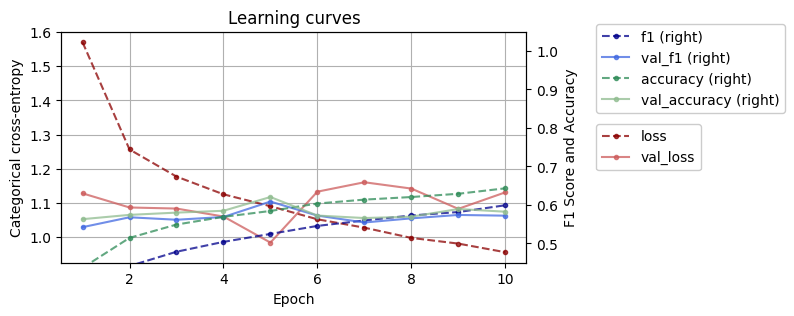

In [ ]:
plot_hist(model2_hist)

While it seemed to lower the overfitting by a lot, that did not translate into better validation scores. It also seems that the validation loss curve did not manage and would not manage to minimize itself more. However, it actually decreased overfitting a lot without decreasing the validation scores by that much (around 5%).

Let's see it in the test set:

In [ ]:
test_scores2 = cnn2.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores2[1]}')

print(f'Test f1_score: {2*test_scores2[-2]*test_scores2[-1]/(test_scores2[-2]+test_scores2[-1])}')

Test Accuracy: 0.5994677543640137
Test f1_score: 0.5856650111842433


Remembering that the f1_score for the test data in our previous model was around 67%, while for this model it's 61%. When comparing the decrease of overfitting to the decrease of test scores, it seems like it did more of the first.

Let's compare model 1 and 2 through their epochs and their behaviour on the test set. On top is the first, below is the latter.

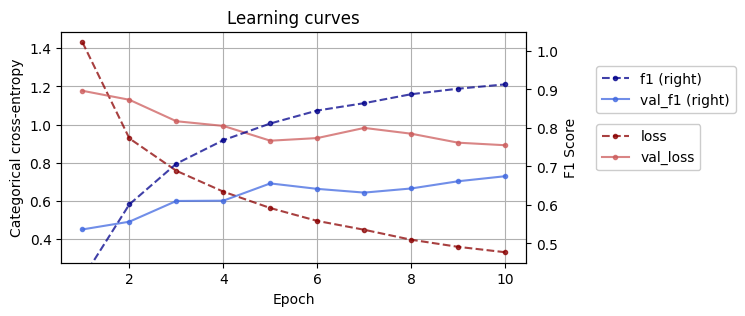

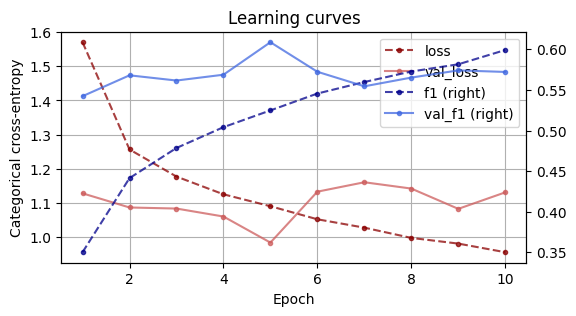

In [ ]:
compare_models(model1_hist,model2_hist)

We see clearly how the biggest difference between the two is the proximity between training and validation f1 scores. We will try to move on with the model that does not have overfitting, as it is probably easier to build on it to improve the scores with the baseline we have now.

In [ ]:
# Getting the labels from ds_test
labels2 =  np.array([])
for x, y in ds_test:
  labels2 = np.concatenate([labels2, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions2 = cnn2.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 3s 72ms/step


Confusion matrix, without normalization
[[  3   3   9   3  10  21   0]
 [  6   7   9   2  19  31   3]
 [ 19   8  20   6  44  65   3]
 [  2   0   0   0   6   9   0]
 [ 17   8  23   3  34  81   1]
 [ 80  54 158  24 240 418  32]
 [  1   1   3   0   4  10   3]]


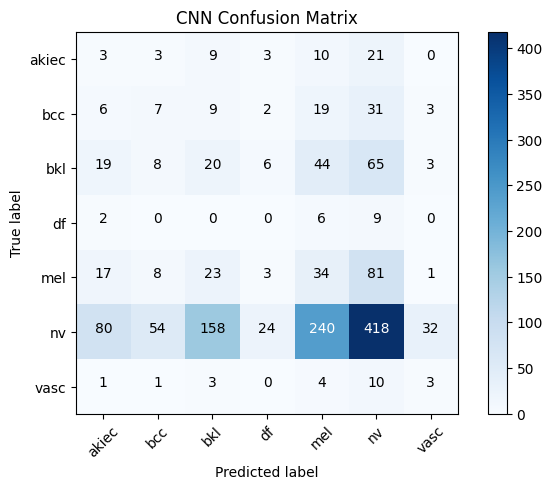

In [ ]:
cm = confusion_matrix(y_true= labels2, y_pred=predictions2.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

Unfortunately, as the performance decreased, the confusion between classes really increased. This could be a problem of underfitting. We will try to improve on it.

### Model 3

Before we moved on to other things, we wanted to try to use a different activation function. By doing that, we could maybe improve on the previous model without increasing the overfitting. We saw that ELU seemed to be a strong alternative to ReLU. It is actually pretty similar, but its derivative is smoother and it can produce negative outputs. It also avoids vanishing gradients but seems to converge faster.

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.elu = layers.Activation("elu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.elu(x)        
        return x

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Augmentation
        self.augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.3), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
                           ],
                           name="my_augmentation_pipeline")
        # # Z-scores 
        self.preprocess = Sequential([self.augmentation,layers.BatchNormalization()])
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.elu = layers.Activation("elu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn3 = CustomResNet(seed=seed)
# Builds the DAG 
cnn3.build(input_shape)
# Check the network
cnn3.summary()

Model: "custom_res_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (64, 128, 128, 3)        0         
 equential)                                                      
                                                                 
 sequential_1 (Sequential)   (64, 128, 128, 3)         12        
                                                                 
 conv2d_27 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_25 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_6 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                  

In [ ]:
model3_hist = compilation(cnn3)

Epoch 1/10
472/472 [==============================] - 76s 154ms/step - loss: 1.4628 - accuracy: 0.4694 - AUROC: 0.8231 - precision: 0.6584 - recall: 0.2648 - val_loss: 1.1828 - val_accuracy: 0.5543 - val_AUROC: 0.8785 - val_precision: 0.7497 - val_recall: 0.4204
Epoch 2/10
472/472 [==============================] - 69s 145ms/step - loss: 1.1618 - accuracy: 0.5604 - AUROC: 0.8851 - precision: 0.7251 - recall: 0.3678 - val_loss: 1.0594 - val_accuracy: 0.5872 - val_AUROC: 0.9072 - val_precision: 0.7054 - val_recall: 0.4850
Epoch 3/10
472/472 [==============================] - 68s 141ms/step - loss: 1.0821 - accuracy: 0.5898 - AUROC: 0.9010 - precision: 0.7375 - recall: 0.4107 - val_loss: 1.1518 - val_accuracy: 0.5743 - val_AUROC: 0.8896 - val_precision: 0.6943 - val_recall: 0.4574
Epoch 4/10
472/472 [==============================] - 69s 144ms/step - loss: 1.0404 - accuracy: 0.6103 - AUROC: 0.9088 - precision: 0.7512 - recall: 0.4393 - val_loss: 1.1184 - val_accuracy: 0.5725 - val_AUROC: 

Plotting the history:

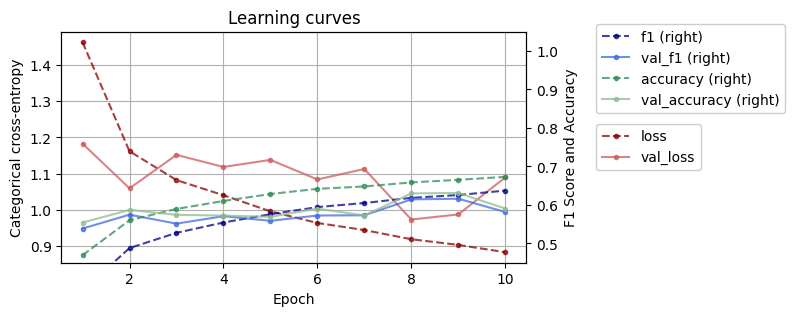

In [ ]:
plot_hist(model3_hist)

Getting the test metrics:

In [ ]:
test_scores3 = cnn3.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores3[1]}')

print(f'Test f1_score: {2*test_scores3[-2]*test_scores3[-1]/(test_scores3[-2]+test_scores3[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores2[1]}\
 and {2*test_scores2[-2]*test_scores2[-1]/(test_scores2[-2]+test_scores2[-1])} respectively")

Test Accuracy: 0.5968064069747925
Test f1_score: 0.5937850830071253
The previous model's accuracy and f1_score for the test set were 0.5994677543640137 and 0.5856650111842433 respectively


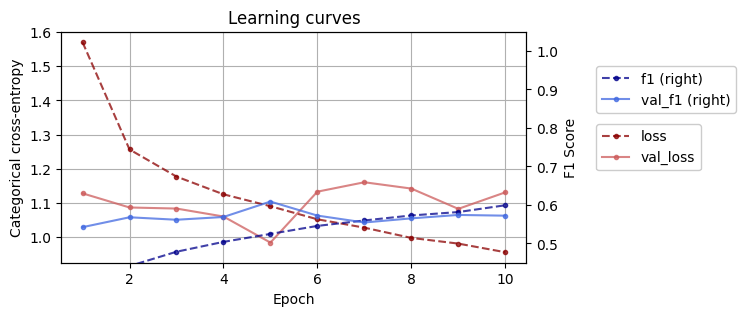

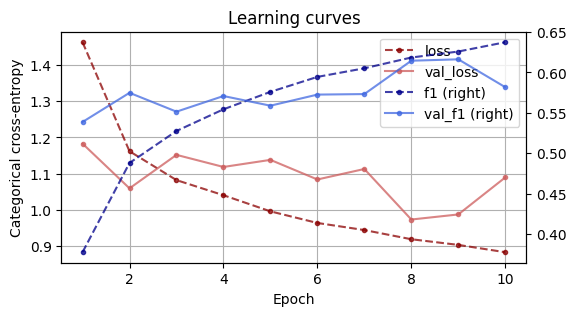

In [ ]:
compare_models(model2_hist,model3_hist)

ReLU seems to have a more stable progress when it comes to the validation metrics. Besides that, ELU just decreased the validation and test scores while increasing training, seemingly contributing to overfitting, so it does not look worth it to keep using ELU instead of ReLU.

In [ ]:
# Getting the labels from ds_test
labels3 =  np.array([])
for x, y in ds_test:
  labels3 = np.concatenate([labels3, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions3 = cnn3.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 4s 125ms/step


Confusion matrix, without normalization
[[  2   1   7   2  13  23   1]
 [  9   2  12   1  21  32   0]
 [ 11   6  23  10  39  74   2]
 [  0   0   1   1   4  10   1]
 [ 13  10  18   8  43  70   5]
 [ 63  46 119  47 283 424  24]
 [  0   4   2   0   6   9   1]]


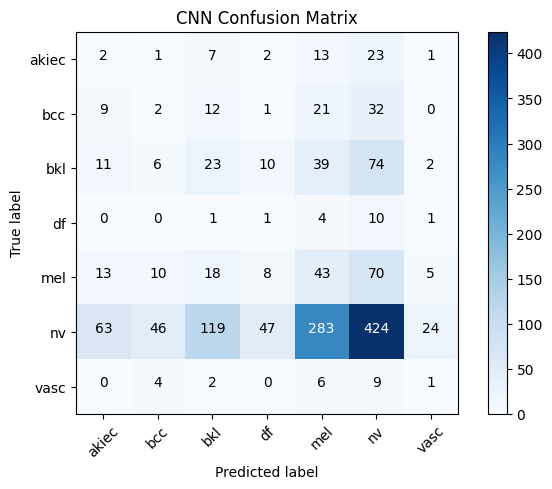

In [ ]:
cm = confusion_matrix(y_true= labels3, y_pred=predictions3.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix did not improve.

### Model 4

Now we will change the model by adding some bottleneck blocks in the part of the model where we stack them. We decided to do a block by block increase of filters by a factor of two, starting from 32 to 256, because using downsample in each block will half the spatial resolution and so doubling the filters may help to not lose representation. This will allow the model to get more insight into the images' features. We think that it may help catching more specific characteristics from the skin marks, but we have to be careful to not add too much overfitting. While it makes sense to see if the image has more important details that tell us the type of cancer, we have fairly simple images, so we'll have to check if this adds too much overfitting. We use squeeze at the same proportion as expand to keep the number of channels the same while decreasing computational load.

#### 4.1. With data augmentation



We had to redefine the blocks to get the relu activation again. The resnet was altered only in the addition of blocks.

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x

class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()

        # Augmentation
        self.augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.3), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
                           ],
                           name="my_augmentation_pipeline")
        # # Z-scores 
        self.preprocess = Sequential([self.augmentation,layers.BatchNormalization()])
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(32, squeeze=2, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(64, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv4 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv5 = BottleneckBlock(256, squeeze=2, expand= 2, downsample=True, seed=seed) 
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn4 = CustomResNet(seed=seed)
# Builds the DAG 
cnn4.build(input_shape)
# Check the network
cnn4.summary()

Model: "custom_res_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (64, 128, 128, 3)        0         
 equential)                                                      
                                                                 
 sequential_2 (Sequential)   (64, 128, 128, 3)         12        
                                                                 
 conv2d_36 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_33 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_8 (Bottlen  multiple                 8992      
 eckBlock)                                                       
                                                  

In [ ]:
model4_hist = compilation(cnn4)

Epoch 1/10
472/472 [==============================] - 74s 150ms/step - loss: 1.8113 - accuracy: 0.3133 - AUROC: 0.7078 - precision: 0.4809 - recall: 0.1132 - val_loss: 1.3554 - val_accuracy: 0.4903 - val_AUROC: 0.8315 - val_precision: 0.7325 - val_recall: 0.3265
Epoch 2/10
472/472 [==============================] - 68s 142ms/step - loss: 1.4792 - accuracy: 0.4279 - AUROC: 0.8073 - precision: 0.6559 - recall: 0.2121 - val_loss: 1.1841 - val_accuracy: 0.5355 - val_AUROC: 0.8833 - val_precision: 0.6897 - val_recall: 0.4228
Epoch 3/10
472/472 [==============================] - 68s 142ms/step - loss: 1.3709 - accuracy: 0.4683 - AUROC: 0.8364 - precision: 0.6867 - recall: 0.2547 - val_loss: 1.0974 - val_accuracy: 0.5637 - val_AUROC: 0.8987 - val_precision: 0.7302 - val_recall: 0.4433
Epoch 4/10
472/472 [==============================] - 69s 143ms/step - loss: 1.2977 - accuracy: 0.4956 - AUROC: 0.8542 - precision: 0.7080 - recall: 0.2818 - val_loss: 1.1532 - val_accuracy: 0.5514 - val_AUROC: 

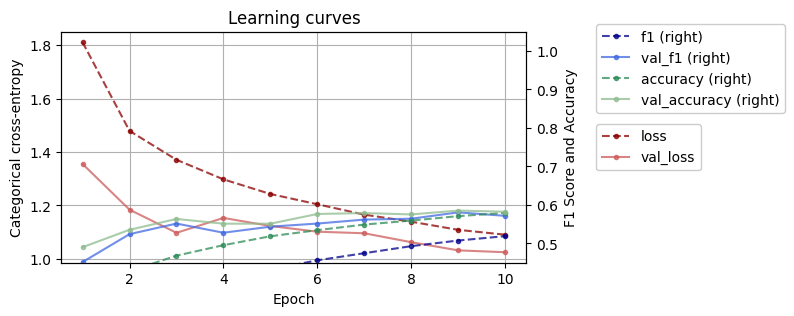

In [ ]:
plot_hist(model4_hist)

In [ ]:
test_scores4 = cnn4.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores4[1]}')

print(f'Test f1_score: {2*test_scores4[-2]*test_scores4[-1]/(test_scores4[-2]+test_scores4[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores3[1]}\
 and {2*test_scores3[-2]*test_scores3[-1]/(test_scores3[-2]+test_scores3[-1])} respectively")

Test Accuracy: 0.5901530385017395
Test f1_score: 0.5789473675681781
The previous model's accuracy and f1_score for the test set were 0.5968064069747925 and 0.5937850830071253 respectively


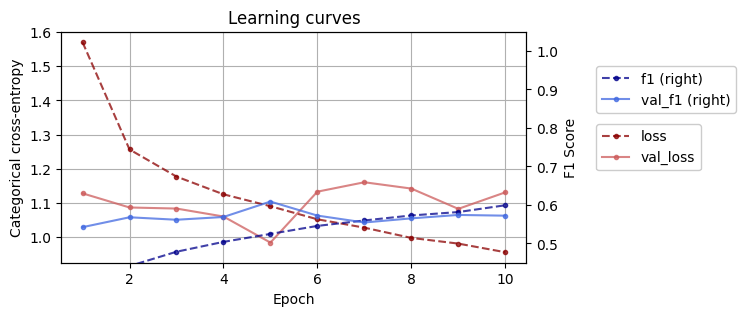

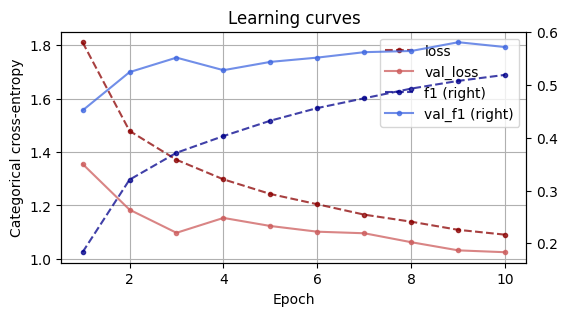

In [ ]:
compare_models(model2_hist, model4_hist)

It's even worse now. Let's try it without data augmentation to see if it is better.

#### 4.2. Without data augmentation

We just took out the data augmentation part from the previous model in the next cell.

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x

class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()

        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(32, squeeze=2, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(64, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv4 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv5 = BottleneckBlock(256, squeeze=2, expand= 2, downsample=True, seed=seed) 
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn42 = CustomResNet(seed=seed)
# Builds the DAG 
cnn42.build(input_shape)
# Check the network
cnn42.summary()

Model: "custom_res_net_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_46 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_47 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_12 (Bottle  multiple                 8992      
 neckBlock)                                                      
                                                                 
 bottleneck_block_13 (Bottle  multiple                 24640     
 neckBlock)                                       

In [ ]:
model42_hist = compilation(cnn42)

Epoch 1/10
472/472 [==============================] - 68s 141ms/step - loss: 1.5790 - accuracy: 0.4168 - AUROC: 0.7823 - precision: 0.6149 - recall: 0.1961 - val_loss: 1.2750 - val_accuracy: 0.5115 - val_AUROC: 0.8555 - val_precision: 0.7372 - val_recall: 0.3558
Epoch 2/10
472/472 [==============================] - 69s 144ms/step - loss: 1.0073 - accuracy: 0.6498 - AUROC: 0.9181 - precision: 0.8160 - recall: 0.4299 - val_loss: 1.1136 - val_accuracy: 0.5672 - val_AUROC: 0.8948 - val_precision: 0.7259 - val_recall: 0.4416
Epoch 3/10
472/472 [==============================] - 67s 140ms/step - loss: 0.7557 - accuracy: 0.7584 - AUROC: 0.9572 - precision: 0.8767 - recall: 0.5990 - val_loss: 1.0740 - val_accuracy: 0.5813 - val_AUROC: 0.9063 - val_precision: 0.6842 - val_recall: 0.4745
Epoch 4/10
472/472 [==============================] - 67s 141ms/step - loss: 0.6146 - accuracy: 0.8114 - AUROC: 0.9727 - precision: 0.8996 - recall: 0.6937 - val_loss: 1.0224 - val_accuracy: 0.6078 - val_AUROC: 

Plot the history:

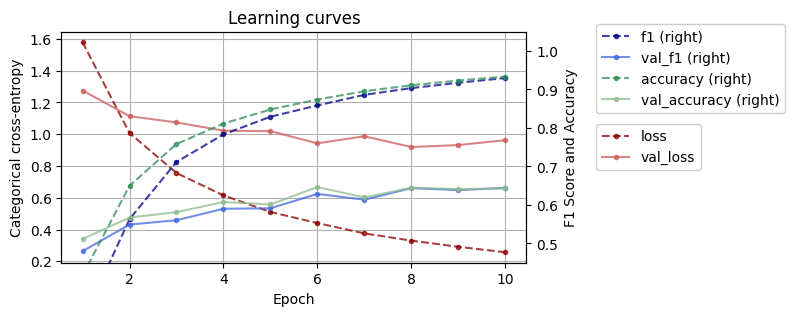

In [ ]:
plot_hist(model42_hist)

On the test set:

In [ ]:
test_scores42 = cnn42.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores42[1]}')

print(f'Test f1_score: {2*test_scores42[-2]*test_scores42[-1]/(test_scores42[-2]+test_scores42[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores4[1]}\
 and {2*test_scores4[-2]*test_scores4[-1]/(test_scores4[-2]+test_scores4[-1])} respectively")

Test Accuracy: 0.6307384967803955
Test f1_score: 0.6266714875911522
The previous model's accuracy and f1_score for the test set were 0.5901530385017395 and 0.5789473675681781 respectively


The scores seem to be better. This may be a better approach after all. On top with data augmentation, on the bottom without.

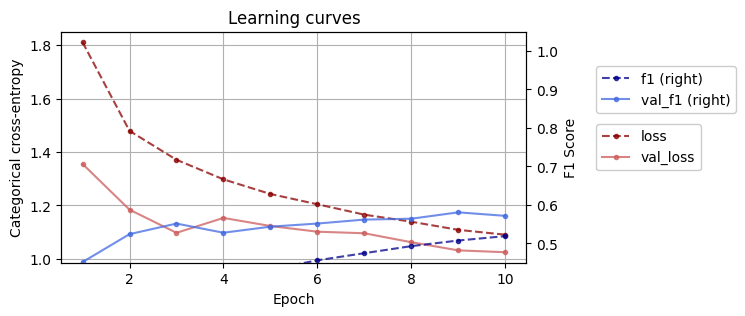

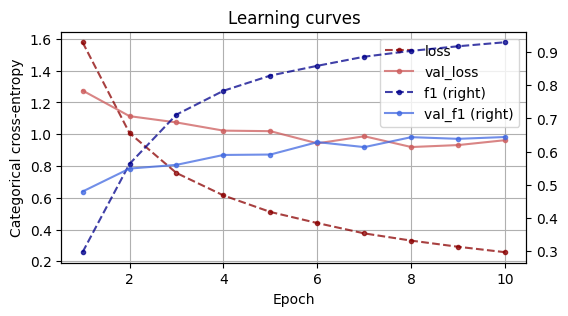

In [ ]:
compare_models(model4_hist, model42_hist)

Without data augmentation, the validation scores seem to have improved. But it is still not better than the first model of them all. So, we will revise our strategy and instead go back to the first model and try to reduce the overfitting without using data augmentation. We will try to reduce the overfitting without affecting the model's validation and test performance.

In the following cell we will compare the current model with the first one.

In [ ]:
test_scores42 = cnn42.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores42[1]}')

print(f'Test f1_score: {2*test_scores42[-2]*test_scores42[-1]/(test_scores42[-2]+test_scores42[-1])}')

print(f"The first model's accuracy and f1_score for the test set were {test_scores1[1]}\
 and {2*test_scores1[-2]*test_scores1[-1]/(test_scores1[-2]+test_scores1[-1])} respectively")

Test Accuracy: 0.6307384967803955
Test f1_score: 0.6266714875911522
The first model's accuracy and f1_score for the test set were 0.6673319935798645 and 0.6573529375147936 respectively


The first one is clearly better.

In [ ]:
# Getting the labels from ds_test
labels42 =  np.array([])
for x, y in ds_test:
  labels42 = np.concatenate([labels42, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions42 = cnn42.predict(x=ds_test,verbose=1)  


24/24 [==============================] - 4s 74ms/step


Confusion matrix, without normalization
[[  1   2   5   0  11  29   1]
 [  4   6   8   1  12  46   0]
 [  2   9  28   1  35  88   2]
 [  1   0   3   0   2  11   0]
 [  9   9  22   1  27  98   1]
 [ 31  72 108  10 197 569  19]
 [  0   0   1   0   4  15   2]]


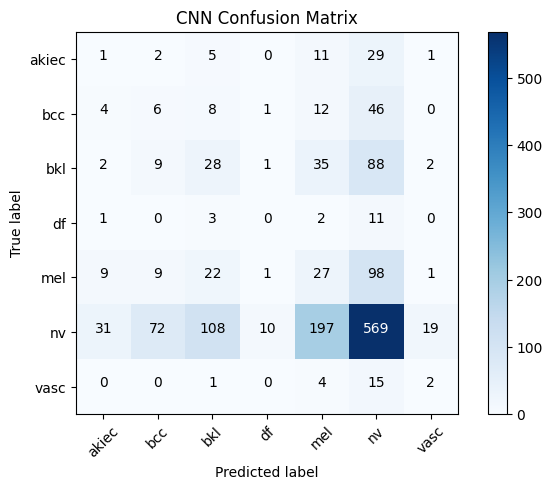

In [ ]:
cm = confusion_matrix(y_true= labels42, y_pred=predictions42.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix is better without data augmentation that with it, but still worse than in the first model.

As we see, when comparing to the first model, it is clear which one is the best. We will go back to the first one and try to reduce overfitting by changing the layers themselves.

### Model 5

As we ended up choosing the model with more overfitting, we will now try to reduce it by decreasing the number of filters in the layers, as more filters tends to induce overfitting. Maybe the layers are catching too many characteristics of the training set, hence overfitting to it.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=32, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(32, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(64, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x
# Create an instance of CustomCNN
cnn5 = CustomResNet(seed=seed)
# Builds the DAG 
cnn5.build(input_shape)
# Check the network
cnn5.summary()

Model: "custom_res_net_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_60 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          multiple                  4736      
                                                                 
 batch_normalization_61 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 bottleneck_block_16 (Bottle  multiple                 15040     
 neckBlock)                                                      
                                                                 
 bottleneck_block_17 (Bottle  multiple                 24640     
 neckBlock)                                       

In [ ]:
model5 = compilation(cnn5)

Epoch 1/10
472/472 [==============================] - 67s 139ms/step - loss: 1.6950 - accuracy: 0.4436 - AUROC: 0.7874 - precision: 0.6577 - recall: 0.2156 - val_loss: 1.1758 - val_accuracy: 0.5320 - val_AUROC: 0.8810 - val_precision: 0.7346 - val_recall: 0.3917
Epoch 2/10
472/472 [==============================] - 68s 142ms/step - loss: 1.1437 - accuracy: 0.5901 - AUROC: 0.8921 - precision: 0.7907 - recall: 0.3249 - val_loss: 1.1449 - val_accuracy: 0.5531 - val_AUROC: 0.8877 - val_precision: 0.7348 - val_recall: 0.4198
Epoch 3/10
472/472 [==============================] - 66s 138ms/step - loss: 1.0065 - accuracy: 0.6602 - AUROC: 0.9199 - precision: 0.8222 - recall: 0.4012 - val_loss: 1.1133 - val_accuracy: 0.5766 - val_AUROC: 0.8952 - val_precision: 0.7150 - val_recall: 0.4404
Epoch 4/10
472/472 [==============================] - 67s 140ms/step - loss: 0.9149 - accuracy: 0.7043 - AUROC: 0.9357 - precision: 0.8474 - recall: 0.4669 - val_loss: 1.1133 - val_accuracy: 0.5837 - val_AUROC: 

Plot the history:

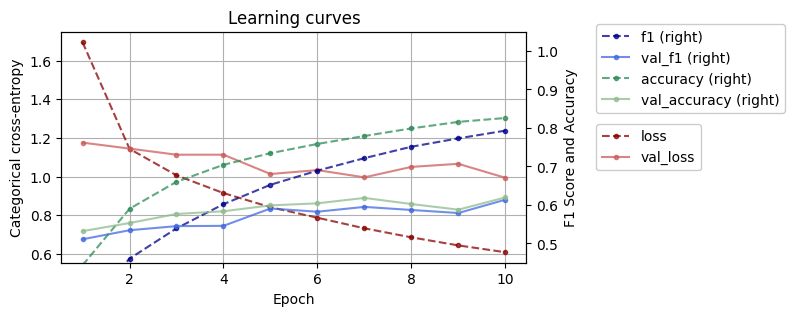

In [ ]:
plot_hist(model5)

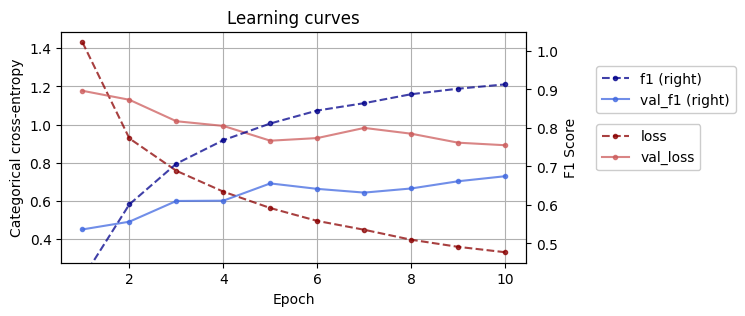

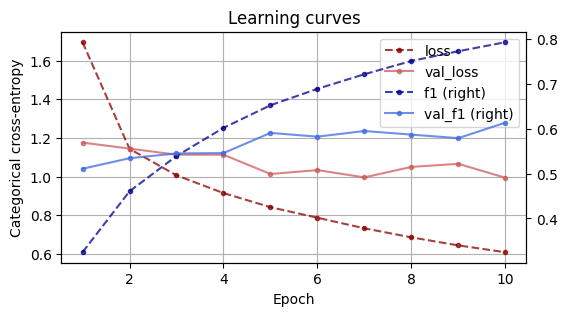

In [ ]:
compare_models(model1_hist, model5)

So, we can see that we clearly managed to decrease the overfitting, as we were proposing to do. However, it decreased the performance of the model by about 5%, which could be worse, but still is not ideal. On the test set:

In [ ]:
test_scores5 = cnn5.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores5[1]}')

print(f'Test f1_score: {2*test_scores5[-2]*test_scores5[-1]/(test_scores5[-2]+test_scores5[-1])}')

print(f"The first model's accuracy and f1_score for the test set were {test_scores1[1]}\
 and {2*test_scores1[-2]*test_scores1[-1]/(test_scores1[-2]+test_scores1[-1])} respectively")

Test Accuracy: 0.6174318194389343
Test f1_score: 0.6124148491071114
The first model's accuracy and f1_score for the test set were 0.6673319935798645 and 0.6573529375147936 respectively


On the test set the decrease was also of about 5%. The positive thing is that we managed to reduce overfitting, but by doing so we decreased the model's performance on unseen data as well. Of course we, in the end, would like a non-overfitting model, but it is more important that we have a product with the best performance in unseen data that it can have. We will try to connect this technique of reducing overfitting with others, so we may be able to get even less overfitting while improving model performance.

In [ ]:
# Getting the labels from ds_test
labels5 =  np.array([])
for x, y in ds_test:
  labels5 = np.concatenate([labels5, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions5 = cnn5.predict(x=ds_test,verbose=1)  


24/24 [==============================] - 3s 73ms/step


Confusion matrix, without normalization
[[  2   3   7   1  12  24   0]
 [  6   6  12   0  16  34   3]
 [  7   7  17   7  33  89   5]
 [  0   0   2   1   1  11   2]
 [  7  18  23   2  27  87   3]
 [ 42  81 142  11 207 501  22]
 [  2   1   3   0   3  13   0]]


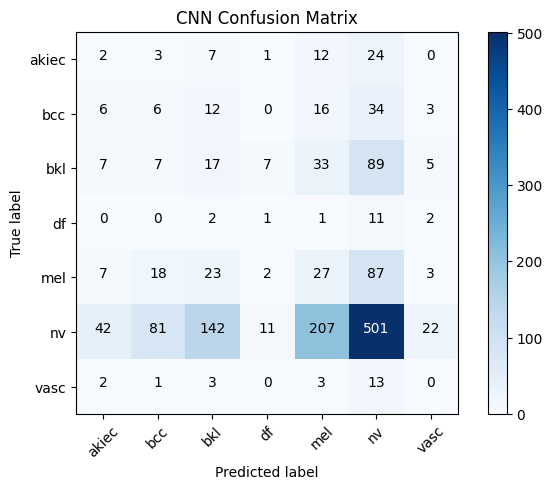

In [ ]:
cm = confusion_matrix(y_true= labels5, y_pred=predictions5.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix is still not looking that good, it is similar to the previous model.

### Model 6

Maybe if we keep the number of filters low but increase the number of block layers, the performance will go up. We could try not downsampling, which would allow us to keep resolution even if we do not double the number of filters, which we've seen that a lower number of filters seems to help with overfitting. So, below we use the same architecture but we define a bottleneck block with no downsample and 32 filters, to repeat them three times in the model itself. So, we increased the number of layers, having 4 blocks now.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=16, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(16, squeeze=1, expand=2, downsample=False, seed=seed)        
        self.conv3 = BottleneckBlock(32, squeeze=1, expand=1, downsample=False, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # repeated blocks with the same filters and no downsampling
        x = self.conv3(x)
        x = self.conv3(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn6 = CustomResNet(seed=seed)
# Builds the DAG 
cnn6.build(input_shape)
# Check the network
cnn6.summary()
# Set control flag to True
train = True

Model: "custom_res_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_20 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          multiple                  2368      
                                                                 
 batch_normalization_21 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 bottleneck_block_4 (Bottlen  multiple                 3936      
 eckBlock)                                                       
                                                                 
 bottleneck_block_5 (Bottlen  multiple                 11744     
 eckBlock)                                        

In [ ]:
model6 = compilation(cnn6)

Epoch 1/10
472/472 [==============================] - 67s 139ms/step - loss: 1.8295 - accuracy: 0.4329 - AUROC: 0.7916 - precision: 0.5598 - recall: 0.2821 - val_loss: 1.3137 - val_accuracy: 0.4938 - val_AUROC: 0.8530 - val_precision: 0.6910 - val_recall: 0.3611
Epoch 2/10
472/472 [==============================] - 67s 139ms/step - loss: 1.2041 - accuracy: 0.5503 - AUROC: 0.8770 - precision: 0.6989 - recall: 0.3782 - val_loss: 1.2587 - val_accuracy: 0.5255 - val_AUROC: 0.8680 - val_precision: 0.6693 - val_recall: 0.4028
Epoch 3/10
472/472 [==============================] - 66s 137ms/step - loss: 1.0653 - accuracy: 0.6050 - AUROC: 0.9044 - precision: 0.7509 - recall: 0.4351 - val_loss: 1.3457 - val_accuracy: 0.4974 - val_AUROC: 0.8515 - val_precision: 0.6328 - val_recall: 0.3876
Epoch 4/10
472/472 [==============================] - 66s 137ms/step - loss: 0.9828 - accuracy: 0.6437 - AUROC: 0.9192 - precision: 0.7733 - recall: 0.4786 - val_loss: 1.2035 - val_accuracy: 0.5385 - val_AUROC: 

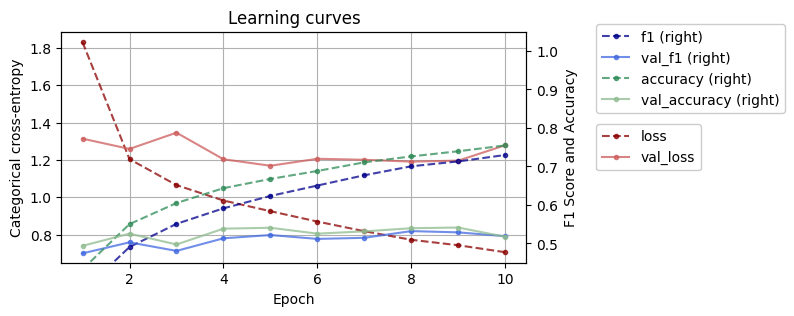

In [ ]:
plot_hist(model6)

We seem to have decreased the model performance overall, but let's check the first model to compare.

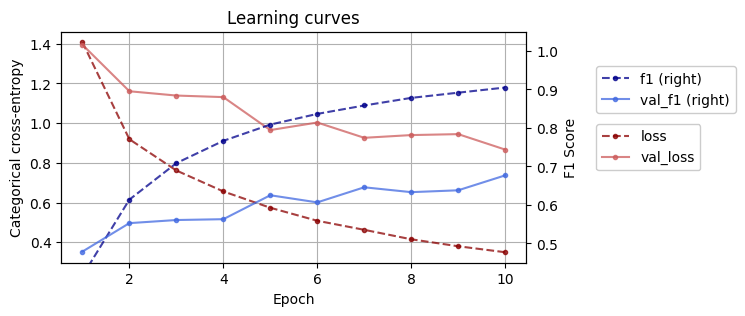

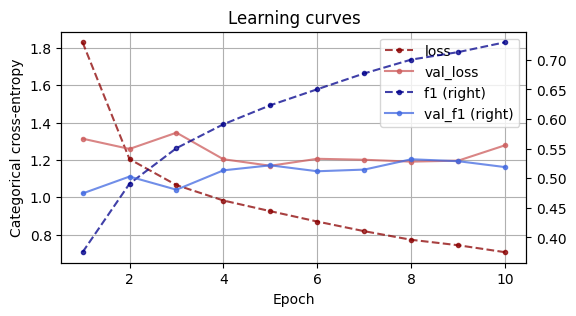

In [ ]:
compare_models(model1_hist, model6)

We decreased the training score, but actually also decreased the validation score, as we can see above.

In [ ]:
test_scores6 = cnn6.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores6[1]}')

print(f'Test f1_score: {2*test_scores6[-2]*test_scores6[-1]/(test_scores6[-2]+test_scores6[-1])}')

print(f"The first model's accuracy and f1_score for the test set were {test_scores1[1]}\
 and {2*test_scores1[-2]*test_scores1[-1]/(test_scores1[-2]+test_scores1[-1])} respectively")

Test Accuracy: 0.5342648029327393
Test f1_score: 0.5414448643708248
The first model's accuracy and f1_score for the test set were 0.6706587076187134 and 0.6666666624959454 respectively


It is worse. Probably this network is too deep.

In [ ]:
# Getting the labels from ds_test
labels6 =  np.array([])
for x, y in ds_test:
  labels6 = np.concatenate([labels6, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions6 = cnn6.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 3s 72ms/step


Confusion matrix, without normalization
[[  3   3   8   3  12  20   0]
 [  4   5  13   5  19  29   2]
 [ 13  12  28   7  46  56   3]
 [  2   1   0   0   6   8   0]
 [  5  13  27   3  40  76   3]
 [ 56  94 164  30 261 377  24]
 [  2   1   4   0   5   8   2]]


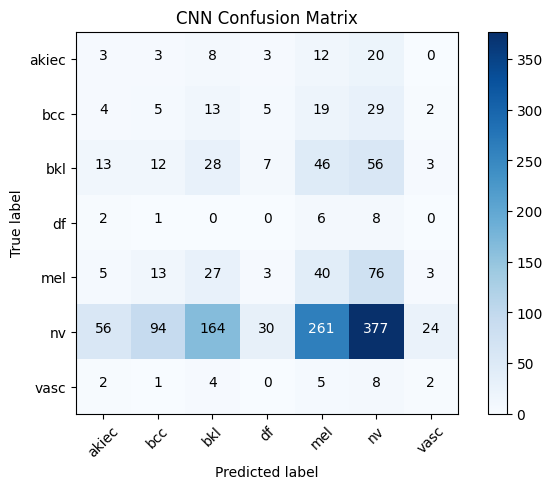

In [ ]:
cm = confusion_matrix(y_true= labels6, y_pred=predictions6.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix is worse.

### Model 7 

Because our images are not that complex, we may benefit from a more shallow neural network. So, here we will try one with just one block. We will increase the number of filters in that block, however, for it to not be too simple. Instead of using various layers with smaller filters, we use one block layer with a bigger filter.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(256, squeeze=1, expand=2, downsample=True, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn7 = CustomResNet(seed=seed)
# Builds the DAG 
cnn7.build(input_shape)
# Check the network
cnn7.summary()

Model: "custom_res_net_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_28 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          multiple                  18944     
                                                                 
 batch_normalization_29 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 bottleneck_block_6 (Bottlen  multiple                 824832    
 eckBlock)                                                       
                                                                 
 dense_3 (Dense)             multiple                  3591      
                                                  

In [ ]:
model7 = compilation(cnn7)

Epoch 1/10
472/472 [==============================] - 69s 142ms/step - loss: 1.0997 - accuracy: 0.6280 - AUROC: 0.9024 - precision: 0.7821 - recall: 0.4250 - val_loss: 0.9372 - val_accuracy: 0.6506 - val_AUROC: 0.9247 - val_precision: 0.8249 - val_recall: 0.5173
Epoch 2/10
472/472 [==============================] - 65s 137ms/step - loss: 0.6867 - accuracy: 0.7914 - AUROC: 0.9653 - precision: 0.8844 - recall: 0.6454 - val_loss: 0.8968 - val_accuracy: 0.6430 - val_AUROC: 0.9332 - val_precision: 0.7406 - val_recall: 0.5449
Epoch 3/10
472/472 [==============================] - 65s 137ms/step - loss: 0.5364 - accuracy: 0.8476 - AUROC: 0.9805 - precision: 0.9169 - recall: 0.7460 - val_loss: 0.8106 - val_accuracy: 0.6935 - val_AUROC: 0.9452 - val_precision: 0.7986 - val_recall: 0.6031
Epoch 4/10
472/472 [==============================] - 67s 139ms/step - loss: 0.4373 - accuracy: 0.8872 - AUROC: 0.9880 - precision: 0.9362 - recall: 0.8100 - val_loss: 0.9417 - val_accuracy: 0.6301 - val_AUROC: 

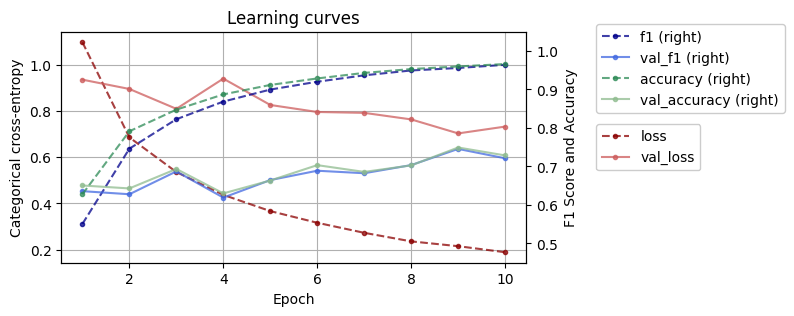

In [ ]:
plot_hist(model7)

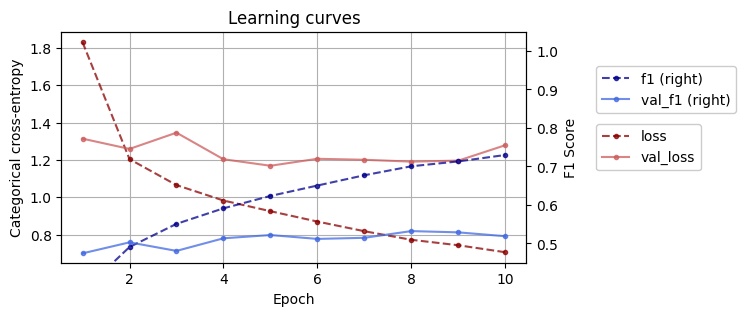

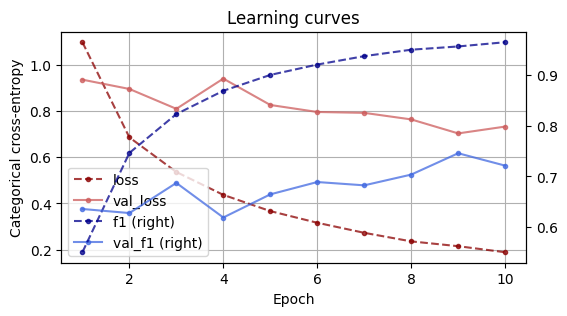

In [ ]:
compare_models(model6, model7)

That actually increased overfitting, but also improved a lot the model's performance.

In [ ]:
test_scores7 = cnn7.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores7[1]}')

print(f'Test f1_score: {2*test_scores7[-2]*test_scores7[-1]/(test_scores7[-2]+test_scores7[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores6[1]}\
 and {2*test_scores6[-2]*test_scores6[-1]/(test_scores6[-2]+test_scores6[-1])} respectively")

Test Accuracy: 0.7159015536308289
Test f1_score: 0.7154121947102441
The previous model's accuracy and f1_score for the test set were 0.5342648029327393 and 0.5414448643708248 respectively


As we can see, it actually improved model performance a lot, even compared with the first model. Model 7 had the overall best performance! 

In [ ]:
# Getting the labels from ds_test
labels7 =  np.array([])
for x, y in ds_test:
  labels7 = np.concatenate([labels7, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions7 = cnn7.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 4s 128ms/step


Confusion matrix, without normalization
[[  2   1   4   0   7  34   1]
 [  5   5   9   0  11  47   0]
 [  7  10  21   2  19 104   2]
 [  0   1   0   0   3  13   0]
 [  7  11  18   2  20 104   5]
 [ 31  57 105   9 146 638  20]
 [  0   2   1   0   3  15   1]]


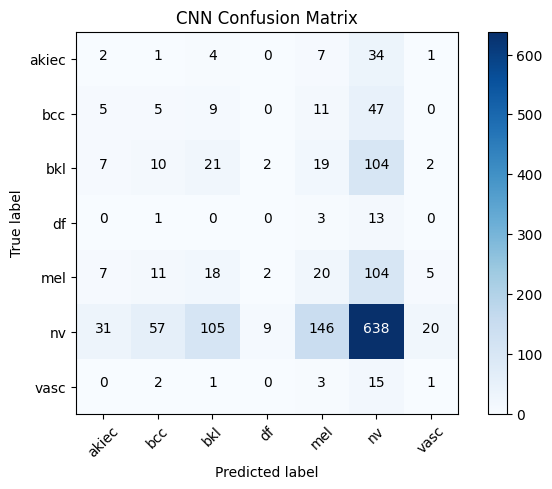

In [ ]:
cm = confusion_matrix(y_true= labels7, y_pred=predictions7.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

Even the confusion matrix seems to be the best so far.

### Model 8

Model 8 will be as shallow as model 7 but we will decrease the number of filters a bit to see if we can reduce overfitting. Instead of 128 for the first layer and then 256 for the batch, we will decrease both by half.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(128, squeeze=1, expand=2, downsample=True, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn8 = CustomResNet(seed=seed)
# Builds the DAG 
cnn8.build(input_shape)
# Check the network
cnn8.summary()

Model: "custom_res_net_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_33 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_34 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_7 (Bottlen  multiple                 207616    
 eckBlock)                                                       
                                                                 
 dense_4 (Dense)             multiple                  1799      
                                                  

In [ ]:
model8 = compilation(cnn8)

Epoch 1/10
472/472 [==============================] - 66s 136ms/step - loss: 1.2787 - accuracy: 0.5576 - AUROC: 0.8691 - precision: 0.7359 - recall: 0.3322 - val_loss: 1.2275 - val_accuracy: 0.5332 - val_AUROC: 0.8723 - val_precision: 0.6861 - val_recall: 0.3940
Epoch 2/10
472/472 [==============================] - 64s 135ms/step - loss: 0.8851 - accuracy: 0.7087 - AUROC: 0.9397 - precision: 0.8440 - recall: 0.4870 - val_loss: 1.1087 - val_accuracy: 0.5807 - val_AUROC: 0.8975 - val_precision: 0.7240 - val_recall: 0.4698
Epoch 3/10
472/472 [==============================] - 65s 135ms/step - loss: 0.7477 - accuracy: 0.7695 - AUROC: 0.9594 - precision: 0.8826 - recall: 0.5902 - val_loss: 0.9517 - val_accuracy: 0.6389 - val_AUROC: 0.9241 - val_precision: 0.7629 - val_recall: 0.5385
Epoch 4/10
472/472 [==============================] - 66s 138ms/step - loss: 0.6510 - accuracy: 0.8100 - AUROC: 0.9707 - precision: 0.9026 - recall: 0.6659 - val_loss: 1.0386 - val_accuracy: 0.5925 - val_AUROC: 

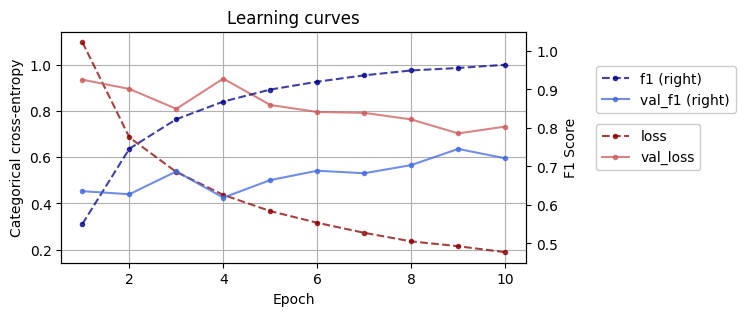

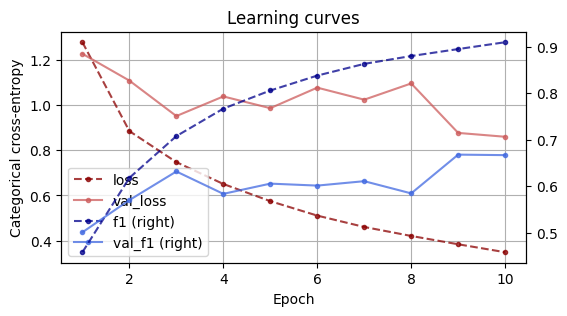

In [ ]:
compare_models(model7, model8)

In [ ]:
test_scores8 = cnn8.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores8[1]}')

print(f'Test f1_score: {2*test_scores8[-2]*test_scores8[-1]/(test_scores8[-2]+test_scores8[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores7[1]}\
 and {2*test_scores7[-2]*test_scores7[-1]/(test_scores7[-2]+test_scores7[-1])} respectively")

Test Accuracy: 0.6786426901817322
Test f1_score: 0.6777041828711823
The previous model's accuracy and f1_score for the test set were 0.7159015536308289 and 0.7154121947102441 respectively


It did decrease overfitting, but with it also dampered performance. Not by that much, but in a final stage we'd prefer higher performance in the test set than a bit less overfitting. Model 9 will still try to reduce overfitting.

In [ ]:
# Getting the labels from ds_test
labels8 =  np.array([])
for x, y in ds_test:
  labels8 = np.concatenate([labels8, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions8 = cnn8.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 4s 117ms/step


Confusion matrix, without normalization
[[  3   2   5   1  10  27   1]
 [  3   6  13   3   9  43   0]
 [  3   7  26   4  24 100   1]
 [  0   1   4   0   0  12   0]
 [  6   7  18   2  28 104   2]
 [ 25  79 147  19 145 567  24]
 [  2   2   3   0   5  10   0]]


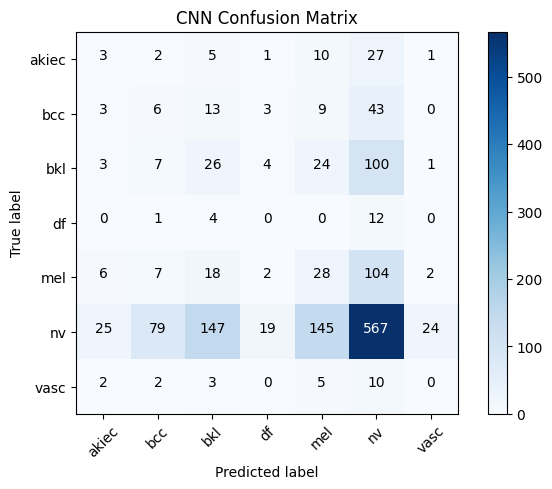

In [ ]:
cm = confusion_matrix(y_true= labels8, y_pred=predictions8.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

Confusion matrix is worse.

### Model 9

Our first to last try will be to not downsample in conv1 and use a size 64 filter in our only bottleneck block. This should reduce overfitting. Let's see if it keeps model performance, though.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=1, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn9 = CustomResNet(seed=seed)
# Builds the DAG 
cnn9.build(input_shape)
# Check the network
cnn9.summary()

Model: "custom_res_net_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_38 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_39 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_8 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 dense_5 (Dense)             multiple                  903       
                                                  

In [ ]:
model9 = compilation(cnn9)

Epoch 1/10
472/472 [==============================] - 72s 147ms/step - loss: 1.4282 - accuracy: 0.5236 - AUROC: 0.8486 - precision: 0.7340 - recall: 0.2892 - val_loss: 1.1034 - val_accuracy: 0.5678 - val_AUROC: 0.8973 - val_precision: 0.7944 - val_recall: 0.3969
Epoch 2/10
472/472 [==============================] - 69s 143ms/step - loss: 0.9954 - accuracy: 0.6525 - AUROC: 0.9216 - precision: 0.8183 - recall: 0.4141 - val_loss: 1.0345 - val_accuracy: 0.5948 - val_AUROC: 0.9094 - val_precision: 0.7654 - val_recall: 0.4674
Epoch 3/10
472/472 [==============================] - 70s 147ms/step - loss: 0.8743 - accuracy: 0.7112 - AUROC: 0.9415 - precision: 0.8468 - recall: 0.4989 - val_loss: 1.0426 - val_accuracy: 0.5913 - val_AUROC: 0.9081 - val_precision: 0.7395 - val_recall: 0.4651
Epoch 4/10
472/472 [==============================] - 70s 146ms/step - loss: 0.7838 - accuracy: 0.7464 - AUROC: 0.9543 - precision: 0.8696 - recall: 0.5673 - val_loss: 1.2768 - val_accuracy: 0.5443 - val_AUROC: 

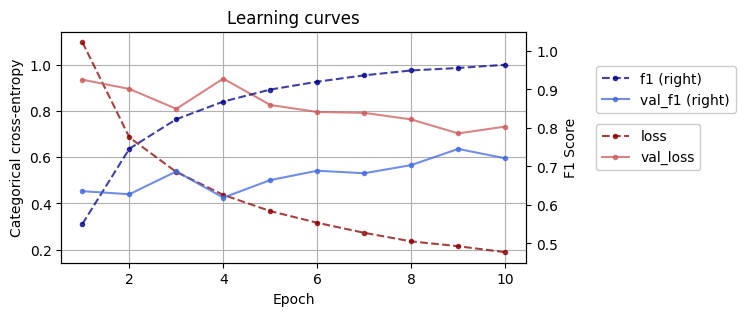

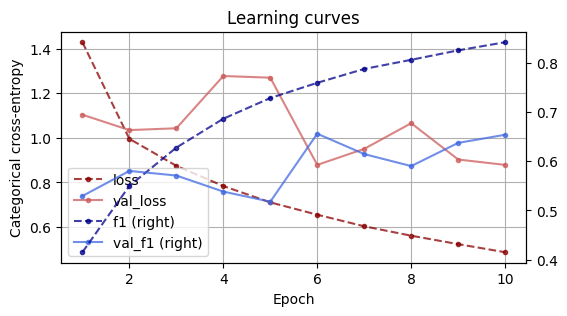

In [ ]:
compare_models(model7, model9)

In [ ]:
test_scores9 = cnn9.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores9[1]}')

print(f'Test f1_score: {2*test_scores9[-2]*test_scores9[-1]/(test_scores9[-2]+test_scores9[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores7[1]}\
 and {2*test_scores7[-2]*test_scores7[-1]/(test_scores7[-2]+test_scores7[-1])} respectively")

Test Accuracy: 0.6553559303283691
Test f1_score: 0.6511283669642034
The previous model's accuracy and f1_score for the test set were 0.7159015536308289 and 0.7154121947102441 respectively


Unfortunately, it decreased the performance too much, in spite of having decreased the overfitting. We will stick to model 7.

In [ ]:
# Getting the labels from ds_test
labels9 =  np.array([])
for x, y in ds_test:
  labels9 = np.concatenate([labels9, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions9 = cnn9.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 4s 130ms/step


Confusion matrix, without normalization
[[  1   2   9   0   9  28   0]
 [  1   4  12   1  18  39   2]
 [  9   7  24   1  25  98   1]
 [  0   0   5   0   1  11   0]
 [  2  15  18   2  43  85   2]
 [ 33  64 113  19 228 526  23]
 [  1   1   2   0   5  13   0]]


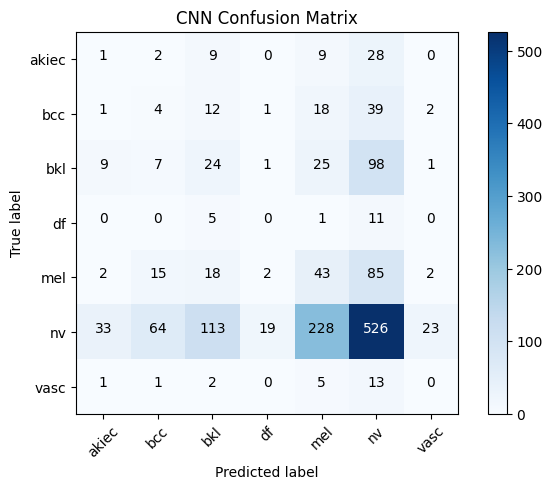

In [ ]:
cm = confusion_matrix(y_true= labels9, y_pred=predictions9.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

We can see that for every model, the problem with the confusion matrix is the same, even if the values change.

### Model 10

We still wanted to try a different optimizer. We decided to try the ADAM optimizer function, as it is a very popular one. The model itself is the same, but this may lead to a better convergence of the loss. We will redefine the same model because we want to be careful about retraining instead of training from scratch.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(256, squeeze=1, expand=2, downsample=True, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn10 = CustomResNet(seed=seed)
# Builds the DAG 
cnn10.build(input_shape)
# Check the network
cnn10.summary()

Model: "custom_res_net_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_43 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_42 (Conv2D)          multiple                  18944     
                                                                 
 batch_normalization_44 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 bottleneck_block_9 (Bottlen  multiple                 824832    
 eckBlock)                                                       
                                                                 
 dense_6 (Dense)             multiple                  3591      
                                                  

In [ ]:
model10 = compilation(cnn10, optimizer = optimizers.Adam(learning_rate=0.001))

Epoch 1/10
472/472 [==============================] - 75s 146ms/step - loss: 0.9113 - accuracy: 0.6871 - AUROC: 0.9328 - precision: 0.7825 - recall: 0.5847 - val_loss: 0.9249 - val_accuracy: 0.6430 - val_AUROC: 0.9330 - val_precision: 0.7187 - val_recall: 0.5895
Epoch 2/10
472/472 [==============================] - 67s 141ms/step - loss: 0.3551 - accuracy: 0.8820 - AUROC: 0.9889 - precision: 0.9098 - recall: 0.8520 - val_loss: 0.9808 - val_accuracy: 0.6794 - val_AUROC: 0.9290 - val_precision: 0.7251 - val_recall: 0.6166
Epoch 3/10
472/472 [==============================] - 68s 143ms/step - loss: 0.2044 - accuracy: 0.9334 - AUROC: 0.9960 - precision: 0.9458 - recall: 0.9214 - val_loss: 0.7738 - val_accuracy: 0.7598 - val_AUROC: 0.9540 - val_precision: 0.7867 - val_recall: 0.7340
Epoch 4/10
472/472 [==============================] - 68s 141ms/step - loss: 0.1137 - accuracy: 0.9652 - AUROC: 0.9988 - precision: 0.9704 - recall: 0.9602 - val_loss: 0.6506 - val_accuracy: 0.7851 - val_AUROC: 

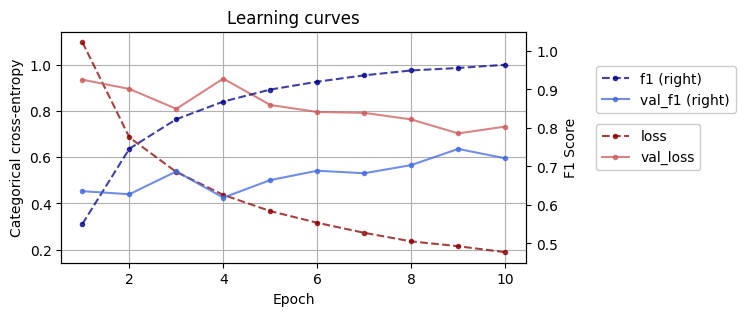

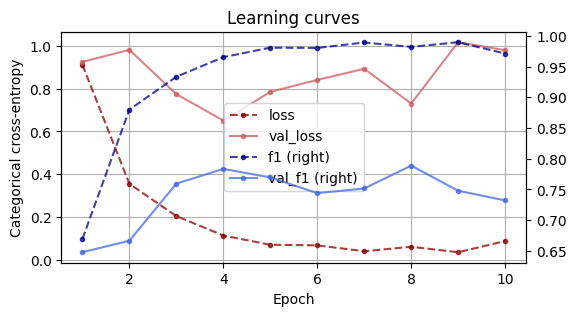

In [ ]:
compare_models(model7, model10)

The loss function was able to converge much better, clearly, using the ADAM function, specially when we look at the training loss.

In [ ]:
test_scores10 = cnn10.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores10[1]}')

print(f'Test f1_score: {2*test_scores10[-2]*test_scores10[-1]/(test_scores10[-2]+test_scores10[-1])}')

print(f"The previous model's accuracy and f1_score for the test set were {test_scores7[1]}\
 and {2*test_scores7[-2]*test_scores7[-1]/(test_scores7[-2]+test_scores7[-1])} respectively")

Test Accuracy: 0.735861599445343
Test f1_score: 0.7296658900279829
The previous model's accuracy and f1_score for the test set were 0.7159015536308289 and 0.7154121947102441 respectively


The test results are better now.

So, in spite of the model being the same, we will use the ADAM optimizer function inside the compilation, because it seems to yield better results.

In [ ]:
# Getting the labels from ds_test
labels10 =  np.array([])
for x, y in ds_test:
  labels10 = np.concatenate([labels10, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictions10 = cnn10.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 4s 110ms/step


Confusion matrix, without normalization
[[  1   3   1   1  14  28   1]
 [  1   4   2   1  21  46   2]
 [  3   4  12   2  42  97   5]
 [  1   1   0   0   4  10   1]
 [  4  11   7   1  37 103   4]
 [ 31  54  68  12 242 578  21]
 [  0   1   3   2   4  12   0]]


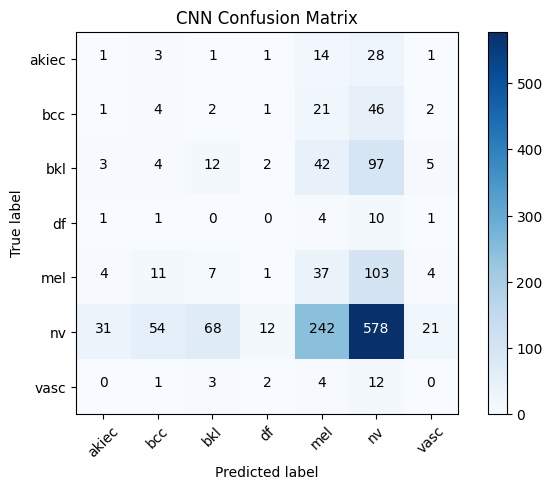

In [ ]:
cm = confusion_matrix(y_true= labels10, y_pred=predictions10.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

### Our Final model

Our final model will be model 10 (or 7). In spite of not having solved totally the problem of overfitting, it is clearly ahead of the other models in terms of performance, specially in the test set. So, we will now train it for more epochs, to evaluate it and have our final model prediction performance. As we have seen, it is best to use ADAM as the optimizer.

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Preprocessing layer 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(256, squeeze=1, expand=2, downsample=True, seed=seed) 
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=7, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_final = CustomResNet(seed=seed)
# Builds the DAG 
cnn_final.build(input_shape)
# Check the network
cnn_final.summary()

Model: "custom_res_net_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_48 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_47 (Conv2D)          multiple                  18944     
                                                                 
 batch_normalization_49 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 bottleneck_block_10 (Bottle  multiple                 824832    
 neckBlock)                                                      
                                                                 
 dense_7 (Dense)             multiple                  3591      
                                                  

In [ ]:
model_final = compilation(cnn_final, epochs = 15, optimizer = optimizers.Adam(learning_rate=0.001))

Epoch 1/15
472/472 [==============================] - 89s 175ms/step - loss: 0.9124 - accuracy: 0.6863 - AUROC: 0.9324 - precision: 0.7779 - recall: 0.5867 - val_loss: 0.8760 - val_accuracy: 0.6518 - val_AUROC: 0.9375 - val_precision: 0.7155 - val_recall: 0.5819
Epoch 2/15
472/472 [==============================] - 69s 146ms/step - loss: 0.3495 - accuracy: 0.8829 - AUROC: 0.9894 - precision: 0.9108 - recall: 0.8517 - val_loss: 0.6182 - val_accuracy: 0.7692 - val_AUROC: 0.9680 - val_precision: 0.8112 - val_recall: 0.7340
Epoch 3/15
472/472 [==============================] - 81s 169ms/step - loss: 0.1903 - accuracy: 0.9389 - AUROC: 0.9968 - precision: 0.9503 - recall: 0.9268 - val_loss: 0.7566 - val_accuracy: 0.7264 - val_AUROC: 0.9566 - val_precision: 0.7602 - val_recall: 0.6982
Epoch 4/15
472/472 [==============================] - 72s 151ms/step - loss: 0.1205 - accuracy: 0.9626 - AUROC: 0.9986 - precision: 0.9679 - recall: 0.9564 - val_loss: 0.9065 - val_accuracy: 0.7146 - val_AUROC: 

We did 15 epochs because previously we had done 35, as we were not expecting the loss function to decrease so much so quickly, but that seems to be the benefit of this model with the ADAM optimizer.

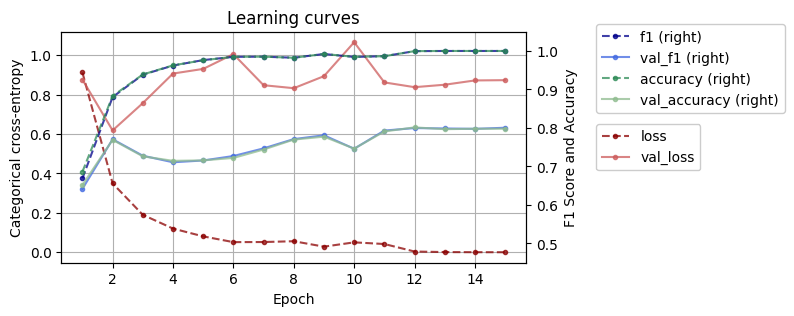

In [ ]:
plot_hist(model_final)

In [ ]:
test_scores_final = cnn_final.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores_final[1]}')

print(f'Test f1_score: {2*test_scores_final[-2]*test_scores_final[-1]/(test_scores_final[-2]+test_scores_final[-1])}')

Test Accuracy: 0.795741856098175
Test f1_score: 0.7977227003620879


The metrics are very satisfactory.

In [ ]:
val_scores_final = cnn_final.evaluate(ds_val, verbose=0)

print(f'Validation Accuracy: {val_scores_final[1]}')

print(f'Validation f1_score: {2*val_scores_final[-2]*val_scores_final[-1]/(val_scores_final[-2]+val_scores_final[-1])}')

Validation Accuracy: 0.7980034947395325
Validation f1_score: 0.8005934691070465


This is our best model. As we see, and we've been talking about, it has a lot of overfitting. But the performance is not that bad, especially when we are accounting for the f1 score, which is more reliable when our test set is imbalanced, which it is. This will be the model we will use with hyperparameter tuning.

In [ ]:
# Getting the labels from ds_test
labelsFM =  np.array([])
for x, y in ds_test:
  labelsFM = np.concatenate([labelsFM, np.argmax(y.numpy(), axis=-1)])

#Predicting the values for ds_test from our cnn model
predictionsFM = cnn_final.predict(x=ds_test,verbose=1)  

24/24 [==============================] - 3s 80ms/step


Confusion matrix, without normalization
[[  1   2   7   1   4  32   2]
 [  4   7   7   0   5  53   1]
 [  1   6  12   1  18 125   2]
 [  1   2   0   0   1  13   0]
 [  7   7  12   1   9 129   2]
 [ 22  41  95   7  85 738  18]
 [  0   2   2   0   1  16   1]]


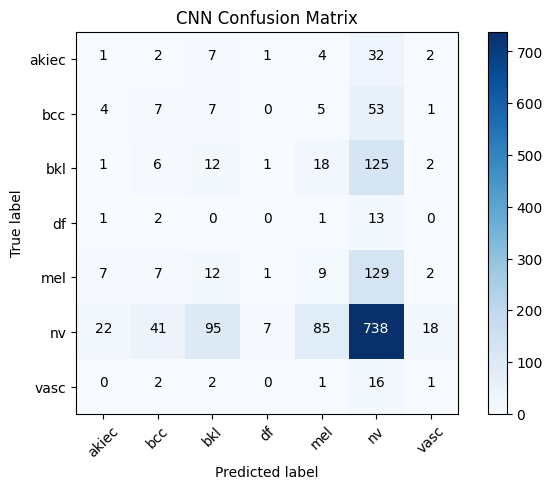

In [ ]:
cm = confusion_matrix(y_true= labelsFM, y_pred=predictionsFM.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=target_labels, title='CNN Confusion Matrix')

The confusion matrix, even though it has the same underlying issue as the other ones, is clearly the best one so far.

The model could be better. Because of the imbalance, it is predicting "nv" well, but it is having trouble predicting the rest of the classes correctly. It still does predict them correctly sometimes, but come of the times either it predicts it as "nv" or sometimes the opposite happens. The model probably did not catch the caviats of each class correctly, unfortunately. The score is not that bad, but it has the help of the majority class being more easily predicted because of its size and variety of images, which makes it have less overfitting for that specific class.